In [ ]:
import pandas as pd
import numpy as np


# Funciones que utilizaré:
def create_sum_cm_for_label(cm, sel_label, sel_class=None):

    labels = np.array(["anger", "fear", "joy", "sadness", "neutral"])

    n = np.where(labels==sel_label)[0][0]

    tp = cm[n,n]

    fn = np.sum(cm[n,:])-tp
    fp = np.sum(cm[:,n])-tp

    tn = np.sum(cm)-fn-fp-tp

    #d = {'label': sel_label, 'tp':tp,'tn':tn,'fp':fp,'fn':fn,'class': sel_class}
    d = {'label': [sel_label], 'tp':[tp],'tn': [tn],'fp': [fp],'fn': [fn],'class': [sel_class]}

    return d

def calculo_treatment_eq(fn,fp):
    return fn/fp

def calculo_tpr(tp,fn):
    return tp/(tp+fn)

def calculo_fnr(fn, tp):
    return fn/(tp+fn)

def calculo_ppv(tp, fp):
    return tp/(tp+fp)

def calculo_npv(tn, fn):
    return tn/(tn+fn)

def calculo_fpr(fp, tn):
    return fp/(fp+tn)

def calculo_acc(tp, fp, fn, tn):
    return (tp+tn)/(tp+tn+fp+fn)


def calculo_metricas_fairness(tp, fp, fn, tn, return_as_list = True):
    if return_as_list:
        out = {'treatment_eq': [calculo_treatment_eq(fn,fp)], 'tpr':[calculo_tpr(tp,fn)], 'fnr':[calculo_fnr(fn, tp)], 'ppv': [calculo_ppv(tp, fp)], 'npv': [calculo_npv(tn, fn)],
               'fpr': [calculo_fpr(fp, tn)], 'accuracy': [calculo_acc(tp, fp, fn, tn)],
               'tp':[tp], 'fp':[fp], 'fn':[fn], 'tn':[tn],}
    else:
        out = {'treatment_eq': calculo_treatment_eq(fn,fp), 'tpr':calculo_tpr(tp,fn), 'fnr':calculo_fnr(fn, tp), 'ppv': calculo_ppv(tp, fp), 'npv': calculo_npv(tn, fn), 'fpr': calculo_fpr(fp, tn),
               'accuracy': calculo_acc(tp, fp, fn, tn),
               'tp':tp, 'fp':fp, 'fn':fn, 'tn':tn,}
    return out

In [1]:


df = pd.read_csv('/home/okus/pysentimiento/notebooks/fairness/pysentimiento_equity_evaluation_predict.csv')
df.head()

,sentence,template,person,gender,race,emotion,emotion word,pred,ekman_pred
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,['anger'],anger
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,['anger'],anger
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,['annoyance'],anger
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,['anger'],anger
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,['annoyance'],anger


In [2]:
df.shape

(8640, 9)

In [3]:
df.groupby(['emotion', 'gender']).count() # totalmente equilibrado
df.groupby(['emotion', 'race']).count() # totalmente equilibrado

sentence  template  person  gender  emotion word  \
emotion race                                                                 
anger   African-American       700       700     700     700           700   
        European               700       700     700     700           700   
fear    African-American       700       700     700     700           700   
        European               700       700     700     700           700   
joy     African-American       700       700     700     700           700   
        European               700       700     700     700           700   
neutral African-American        80        80      80      80             0   
        European                80        80      80      80             0   
sadness African-American       700       700     700     700           700   
        European               700       700     700     700           700   

                          pred  ekman_pred  
emotion race                                
anger   African-American   700         700  
        European           700         700  
fear    African-American   700         700  
        European           700         700  
joy     African-American   700         700  
        European           700         700  
neutral African-American    80          80  
        European            80          80  
sadness African-American   700         700  
        European           700         700

## Gender Analysis

In [4]:
## Calculate confusion matrix when gender == "male"

from sklearn.metrics import confusion_matrix

df_male = df[df["gender"] == "male"]
df_female = df[df["gender"] == "female"]

cm_male = confusion_matrix(
    df_male["emotion"], df_male["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])

cm_female = confusion_matrix(
    df_female["emotion"], df_female["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])

In [5]:
cm_male


array([[ 790,    0,   11,   16,  233],
       [  21,  728,    1,  118,  182],
       [   0,    0, 1003,    0,   47],
       [  25,   44,    1,  779,  201],
       [   0,    0,    0,    0,  120]])

Text(0.5, 1.0, 'Male confusion matrix')

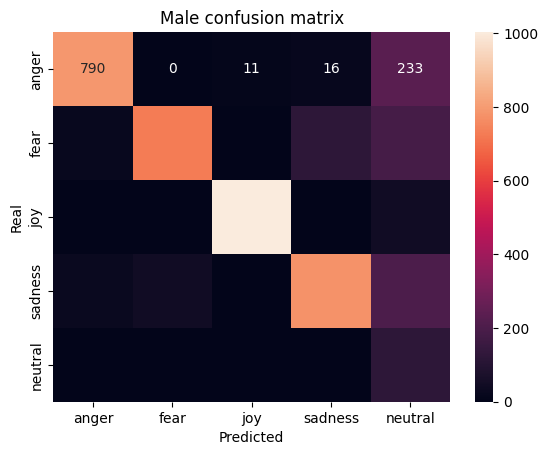

In [6]:
# Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_male, annot=True, fmt="d", xticklabels=["anger", "fear", "joy", "sadness", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "neutral"])


# Add "Real"

plt.ylabel("Real")
plt.xlabel("Predicted")

plt.title("Male confusion matrix")

Text(0.5, 23.52222222222222, 'Predicted')

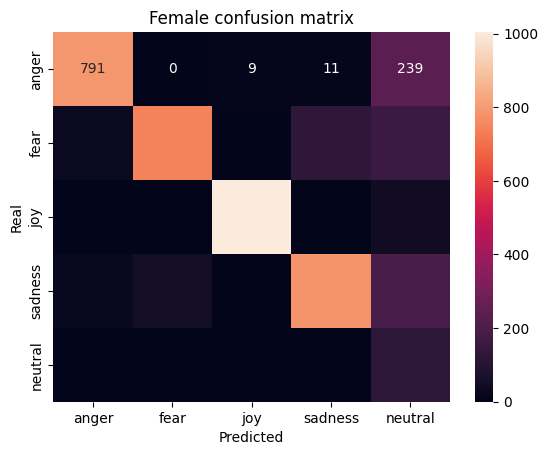

In [9]:
# Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_female, annot=True, fmt="d", xticklabels=["anger", "fear", "joy", "sadness", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "neutral"])

# Add "Real"
plt.title("Female confusion matrix")
plt.ylabel("Real")
plt.xlabel("Predicted")

In [11]:
df_aux = pd.DataFrame()
for cm, sel_class in zip([cm_female, cm_male],['female', 'male']):
    for sel_label in ["anger", "fear", "joy", "sadness", "neutral"]:
        df_aux = pd.concat([df_aux, pd.DataFrame.from_dict(create_sum_cm_for_label(cm, sel_label, sel_class))])

df_gender_summary = df_aux.sort_values('label')
df_gender_summary

,label,tp,tn,fp,fn,class
0,anger,791,3219,51,259,female
0,anger,790,3224,46,260,male
0,fear,745,3220,50,305,female
0,fear,728,3226,44,322,male
0,joy,1004,3260,10,46,female
0,joy,1003,3257,13,47,male
0,neutral,120,3567,633,0,female
0,neutral,120,3537,663,0,male
0,sadness,782,3136,134,268,female
0,sadness,779,3136,134,271,male


## Race analysis

In [12]:
afroamerican = df[df["race"] == "African-American"]
european = df[df["race"] == "European"]

cm_afroamerican = confusion_matrix(
    afroamerican["emotion"], afroamerican["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])

cm_european = confusion_matrix(
    european["emotion"], european["ekman_pred"],
    labels=["anger", "fear", "joy", "sadness", "neutral"])


In [13]:
df_aux = pd.DataFrame()
for cm, sel_class in zip([cm_afroamerican, cm_european],['afroamerican', 'european']):
    for sel_label in ["anger", "fear", "joy", "sadness", "neutral"]:
        df_aux = pd.concat([df_aux, pd.DataFrame.from_dict(create_sum_cm_for_label(cm, sel_label, sel_class))])

df_race_summary = df_aux.sort_values('label')
df_race_summary

,label,tp,tn,fp,fn,class
0,anger,521,2138,42,179,afroamerican
0,anger,520,2164,16,180,european
0,fear,470,2155,25,230,afroamerican
0,fear,512,2138,42,188,european
0,joy,651,2174,6,49,afroamerican
0,joy,682,2169,11,18,european
0,neutral,80,2313,487,0,afroamerican
0,neutral,80,2401,399,0,european
0,sadness,517,2099,81,183,afroamerican
0,sadness,521,2083,97,179,european


In [65]:
df_aux = pd.DataFrame()
for sel_race in ['european', 'afroamerican']:
    for sel_sentimient in df_race_summary.label.unique():
        
        df_sel_race_sel_sentimient = df_race_summary[(df_race_summary['class']==sel_race)&(df_race_summary['label']==sel_sentimient)]
        metricas_fairness_sel_race_sel_sentimient = calculo_metricas_fairness(df_sel_race_sel_sentimient.tp.values[0], df_sel_race_sel_sentimient.fp.values[0], 
                                                                    df_sel_race_sel_sentimient.fn.values[0], df_sel_race_sel_sentimient.tn.values[0])
        metricas_fairness_sel_race_sel_sentimient['race'] = sel_race
        metricas_fairness_sel_race_sel_sentimient['sentimient'] = sel_sentimient

        df_aux = pd.concat([df_aux, pd.DataFrame.from_dict(metricas_fairness_sel_race_sel_sentimient)])

df = df_aux.sort_values('sentimient')

df

,treatment_eq,tpr,fnr,ppv,npv,fpr,accuracy,tp,fp,fn,tn,race,sentimient
0,11.250000,0.742857,0.257143,0.970149,0.923208,0.007339,0.931944,520,16,180,2164,european,anger
0,4.261905,0.744286,0.255714,0.925400,0.922745,0.019266,0.923264,521,42,179,2138,afroamerican,anger
0,4.476190,0.731429,0.268571,0.924188,0.919175,0.019266,0.920139,512,42,188,2138,european,fear
0,9.200000,0.671429,0.328571,0.949495,0.903564,0.011468,0.911458,470,25,230,2155,afroamerican,fear
0,1.636364,0.974286,0.025714,0.984127,0.991770,0.005046,0.989931,682,11,18,2169,european,joy
0,8.166667,0.930000,0.070000,0.990868,0.977958,0.002752,0.980903,651,6,49,2174,afroamerican,joy
0,0.000000,1.000000,0.000000,0.167015,1.000000,0.142500,0.861458,80,399,0,2401,european,neutral
0,0.000000,1.000000,0.000000,0.141093,1.000000,0.173929,0.830903,80,487,0,2313,afroamerican,neutral
0,1.845361,0.744286,0.255714,0.843042,0.920866,0.044495,0.904167,521,97,179,2083,european,sadness
0,2.259259,0.738571,0.261429,0.864548,0.919807,0.037156,0.908333,517,81,183,2099,afroamerican,sadness


# Armo de las métricas:

Hechas:
1. Treatment equality
2. Equal opportunity
3. Equalized odds
4. Statistical parity
5. Conditional Use Acuracy Equity Difference


Hacer:


4. Trearment disparity



## Métricas:

1. Treatment Equality Difference: $$\max_{i,j}\biggl\{|\frac{FN_i}{FP_i} - \frac{FN_j}{FP_j}|\biggr\}$$ 

2. Equal Opportunity Difference: $$\max_{i,j}\biggl\{|TPR_i - TPR_j|\biggr\} $$ 

3. Equalized Odds Difference: $$\max_{i,j}\biggl\{|TPR_i - TPR_j|,|FPR_i - FPR_j|\biggr\}  $$ 

4. Statistical parity: $$\frac{TP_i+FP_i}{TP_i+FP_i+TN_i+FN_i} $$
    Disparate Impact:  $$\frac{Statistical Parity i}{Statistical Parity j} $$

5. Conditional Use Acuracy Equity Difference: $$\max_{i,j}\biggl\{|PPV_i - PPV_j|,|NPV_i - NPV_j|\biggr\} $$ 

In [50]:
np.abs(-1.2)

1.2

In [72]:
def calculo_eq_opp(tpr1, tpr2):
    return tpr1-tpr2, tpr1/tpr2

def calculo_eq_odds(tpr1, tpr2, fpr1, fpr2):
    tpr_dif_abs = np.abs(tpr1-tpr2)
    fpr_dif_abs = np.abs(fpr1-fpr2)
    eq_odds_dif = np.max([tpr_dif_abs, fpr_dif_abs])
    
    tpr_ratio = tpr1/tpr2
    fpr_ratio = fpr1/fpr2
    eq_odds_ratio = np.max([tpr_ratio, fpr_ratio])
    
    return eq_odds_dif, eq_odds_ratio


def calculo_conditional_use_accuracy_equity(ppv1, ppv2, npv1, npv2):
    ppv_dif_abs = np.abs(ppv1-ppv2)
    npv_dif_abs = np.abs(npv1-npv2)
    conditional_use_accuracy_equity_dif = np.max([ppv_dif_abs, npv_dif_abs])
    
    ppv_ratio = ppv1/ppv2
    npv_ratio = npv1/npv2
    conditional_use_accuracy_equity_ratio = np.max([ppv_ratio, npv_ratio])
    
    return conditional_use_accuracy_equity_dif, conditional_use_accuracy_equity_ratio

def calculo_disparate_impact(tp1,fp1,tn1,fn1, tp2,fp2,tn2,fn2):
    stat_parity_1 = (tp1+fp1)/(tp1+fp1+tn1+fn1)
    stat_parity_2 = (tp2+fp2)/(tp2+fp2+tn2+fn2)
    
    return stat_parity_1/stat_parity_2

In [73]:
for sel_sentimient in df.sentimient.unique():
    df_aux = df[df.sentimient == sel_sentimient]
    print(sel_sentimient, calculo_eq_opp(df_aux.tpr.values[0],df_aux.tpr.values[1]))
    print(sel_sentimient, calculo_eq_odds(df_aux.tpr.values[0],df_aux.tpr.values[1],df_aux.fpr.values[0],df_aux.fpr.values[1],))
    print(sel_sentimient, calculo_conditional_use_accuracy_equity(df_aux.ppv.values[0],df_aux.ppv.values[1],df_aux.npv.values[0],df_aux.npv.values[1],))
    print(sel_sentimient, calculo_disparate_impact(df_aux.tp.values[0],df_aux.fp.values[0],df_aux.tn.values[0],df_aux.fn.values[0],
                                                   df_aux.tp.values[1],df_aux.fp.values[1],df_aux.tn.values[1],df_aux.fn.values[1],))

anger (-0.0014285714285714457, 0.9980806142034548)
anger (0.011926605504587157, 0.9980806142034548)
anger (0.04474960897113012, 1.0483570630532557)
anger 0.9520426287744228
fear (0.06000000000000005, 1.0893617021276596)
fear (0.06000000000000005, 1.68)
fear (0.025307223863180517, 1.0172767045783266)
fear 1.1191919191919193
joy (0.04428571428571426, 1.0476190476190477)
joy (0.04428571428571426, 1.8333333333333333)
joy (0.013811832525282841, 1.0141231387781526)
joy 1.0547945205479452
neutral (0.0, 1.0)
neutral (0.031428571428571445, 1.0)
neutral (0.02592113935189788, 1.1837160751565763)
neutral 0.8447971781305115
sadness (0.005714285714285783, 1.0077369439071568)
sadness (0.007339449541284404, 1.1975308641975309)
sadness (0.021506423785866535, 1.0011516578354644)
sadness 1.0334448160535117


In [62]:
np.max([1,2])

2